![picture](https://drive.google.com/uc?export=view&id=1RsJiUkBb2Fy00EvMSlxKB1-0aR_hXgmY)

# **Inroduction**
One major obstacle towards AI is the poor ability of models to solve new problems quicker, and without forgetting previously acquired knowledge. To better
understand this issue, we study the problem of continual learning, where the model
observes, once and one by one, examples concerning a sequence of tasks. First,
we propose a set of metrics to evaluate models learning over a continuum of data.
These metrics characterize models not only by their test accuracy, but also in terms
of their ability to transfer knowledge across tasks. Second, we propose a model
for continual learning, called  Elastic Weights Consolidation (EWC) that alleviates
forgetting, while allowing beneficial transfer of knowledge to previous tasks. Our
experiments on variants of the MNIST , called Rotated MNIST 

#Data Preparation
We are using Pytorch API to perform the analysis and we are downloading the mnist dataset available in Continual AI Colab's repository


In [1]:
# !pip install --upgrade torch torchvision
import torch
print('Torch', torch.__version__, 'CUDA', torch.version.cuda)

Torch 1.6.0+cu101 CUDA 10.1


In [2]:
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from numpy import load
import random
from PIL import Image

In [3]:
# Download dataset from Continual AI Colab's repository
!git clone https://github.com/ContinualAI/colab.git continualai/colab

Cloning into 'continualai/colab'...
remote: Enumerating objects: 120, done.
remote: Total 120 (delta 0), reused 0 (delta 0), pack-reused 120
Receiving objects: 100% (120/120), 207.33 KiB | 393.00 KiB/s, done.
Resolving deltas: 100% (42/42), done.


In [4]:
# Import the script 
from continualai.colab.scripts import mnist
mnist.init()

Download complete.
Save complete.


In [5]:
# Load dataset:
x_train, t_train, x_test, t_test = mnist.load()
print("x_train dim and type: ", x_train.shape, x_train.dtype)
print("t_train dim and type: ", t_train.shape, t_train.dtype)
print("x_test dim and type: ", x_test.shape, x_test.dtype)
print("t_test dim and type: ", t_test.shape, t_test.dtype)

x_train dim and type:  (60000, 1, 28, 28) float32
t_train dim and type:  (60000,) uint8
x_test dim and type:  (10000, 1, 28, 28) float32
t_test dim and type:  (10000,) uint8


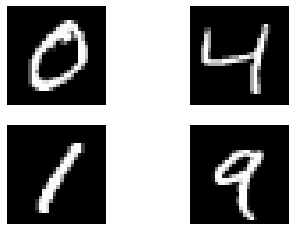

In [6]:
# Display 4 images inside dataset
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(x_train[1, 0], cmap="gray")
axarr[0,1].imshow(x_train[2, 0], cmap="gray")
axarr[1,0].imshow(x_train[3, 0], cmap="gray")
axarr[1,1].imshow(x_train[4, 0], cmap="gray")
np.vectorize(lambda ax:ax.axis('off'))(axarr);

In [7]:
# switch to cuda GPU
# Q: Why using GPU? 
# A: cuz for some highly parallelizable problems, GPU can ensure us speedup computation. Also due to their multi-core architecture,
# they are much fast and efficient for matrix multiplication operations.

use_cuda = True
use_cuda = use_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu");
print(device)
# Use torch.manual_seed() to seed the RNG our CUDA devices
torch.manual_seed(2)

cuda


#Defining the model with original dataset
 After comparing CNN and MLP's performance on MNIST, we decided to use MLP as the basic network architecture for this project
Our MLP model consists of four fully connected hidden layers with 512, 256,128,10 units in each hidden layer by themselves.
And use Rectified Linear Units(ReLUs) as activation function for each hidden layer.
We also include a dropout layer (p=0.2) to precent the overfitting of data

In [8]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, input):
        x = F.relu(self.fc1(input))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc4(x))
        return x

##Optimization
We also compared different optimizers' performance including Stochastic Gradient Descent(SGD).SGD with momentum, RMSprop and Adam. And we decided to use Adam since it has the highest training and validation accuracies
for each epoch(94%~97%) while SGD has the lowest for each epoch where yields (84% ~ 89%).

###Batch size
Here we also tried out different batch_size ranging from 128 to 512, and finally decided to use batch size as 200 since this gave us the highest accuracy among all others 

In [9]:
model = MLP().to(device)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer =  optim.Adadelta(model.parameters())


batch_size = 200

##Training the model

In [10]:
def train(model, device, x_train, t_train, optimizer, epoch):
    model.train()
    
    for start in range(0, len(t_train)-1, batch_size):
      end = start + batch_size
      x, y = torch.from_numpy(x_train[start:end]), torch.from_numpy(t_train[start:end]).long()
      x, y = x.to(device), y.to(device)
#     Reshape the input size for the input of MLP:
      x = x.view(x.size(0), -1)
#     Set the gradients to zero before starting to do backpropragation:
      optimizer.zero_grad()

      output = model(x)
      loss = F.cross_entropy(output, y)
      loss.backward()
      optimizer.step()
    print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

def test(model, device, x_test, t_test):
#   Use model.eval() for batch norm and dropouts
    model.eval()
    test_loss = 0
    correct = 0
    for start in range(0, len(t_test)-1, batch_size):
      end = start + batch_size
      with torch.no_grad():
        x, y = torch.from_numpy(x_test[start:end]), torch.from_numpy(t_test[start:end]).long()
        x, y = x.to(device), y.to(device)
        x = x.view(x.size(0), -1)
        output = model(x)
        # sum up batch loss
        test_loss += F.cross_entropy(output, y).item() 
        # get the index of the max logit
        pred = output.max(1, keepdim=True)[1] 
        correct += pred.eq(y.view_as(pred)).sum().item()

    test_loss /= len(t_train)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(t_test),
        100. * correct / len(t_test)))
    return 100. * correct / len(t_test)

In [11]:
for epoch in range(1, 3):
  train(model, device, x_train, t_train, optimizer, epoch)
  test(model, device, x_test, t_test)

Train Epoch: 1 	Loss: 0.351401
Test set: Average loss: 0.0004, Accuracy: 8321/10000 (83%)

Train Epoch: 2 	Loss: 0.333356
Test set: Average loss: 0.0003, Accuracy: 8560/10000 (86%)



##Summary of testing with the original dataset
 Since we used the starter code from Continual AI Colab's repository, in the starter code, the network architecture used CNN and the final accuracy is 94%. By changing architecture and improving parameterization we imporve the accuracy to 97%. By improving the basic architecture, it will hlep to improve the performance of continual learning task on different model

#Creation of rotated dataset to use it with EWC
We are performing the rotation with 360 degrees and store the results in rotated mnist dataset

In [12]:
# Load MNIST again for rotated 
x_train_2, t_train_2, x_test_2, t_test_2 = mnist.load()

print("x_train dim and type: ", x_train_2.shape, x_train_2.dtype)
print("t_train dim and type: ", t_train_2.shape, t_train_2.dtype)
print("x_test dim and type: ", x_test_2.shape, x_test_2.dtype)
print("t_test dim and type: ", t_test_2.shape, t_test_2.dtype)

x_train dim and type:  (60000, 1, 28, 28) float32
t_train dim and type:  (60000,) uint8
x_test dim and type:  (10000, 1, 28, 28) float32
t_test dim and type:  (10000,) uint8


In [13]:
# and the data format is consistant
def rotate_dataset(d, seed):
    torch.manual_seed(seed)
    print("starting rotation...")
    rand_rotate = torch.rand(1)
#     print( rand_rotate)
#   for each rotation of each task, we rotate them for a random angle between 0 to 360
    rotation = 360*rand_rotate 
#     print(rotation)
    rotated_mnist = np.ndarray((d.shape),np.float32)
    result = []
    new_d=[]

    for i in range(d.shape[0]):
        img = Image.fromarray(d[i][0])
#       Use the roattion fuction from PIL's Image Library 
        img = img.rotate(rotation)
        rotated_mnist[i,0]= img

    return rotated_mnist

starting rotation...
starting rotation...
x_train dim and type:  (60000, 1, 28, 28) float32
x_test dim and type:  (10000, 1, 28, 28) float32


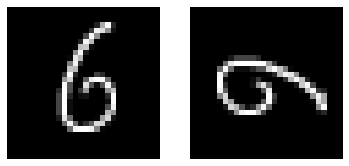

In [14]:
# Rotate MNIST dataset 
x_train_2 = rotate_dataset(x_train, 1)
x_test_2 = rotate_dataset(x_test, 1)
print("x_train dim and type: ", x_train_2.shape, x_train_2.dtype)
print("x_test dim and type: ", x_test_2.shape, x_test_2.dtype)
# Displat rotated MNIST dataset
f, axarr = plt.subplots(1,2)
axarr[0].imshow(x_train[18,0], cmap="gray")
axarr[1].imshow(x_train_2[18,0], cmap="gray")
np.vectorize(lambda ax:ax.axis('off'))(axarr);

In [15]:
# Test our model trained by non-rorated on rotated which only has 18% accuracy.
print("Testing on the first task:")
test(model, device, x_test, t_test)

print("Testing on the second task:")
test(model, device, x_test_2, t_test);

Testing on the first task:
Test set: Average loss: 0.0003, Accuracy: 8560/10000 (86%)

Testing on the second task:
Test set: Average loss: 0.0043, Accuracy: 1844/10000 (18%)



In [16]:
# Finetune  our model using the new roated training set can reach a good acc of 97% 
for epoch in range(1, 3):
  train(model, device, x_train_2, t_train, optimizer, epoch)
  test(model, device, x_test_2, t_test)

Train Epoch: 1 	Loss: 0.335003
Test set: Average loss: 0.0003, Accuracy: 8448/10000 (84%)

Train Epoch: 2 	Loss: 0.094863
Test set: Average loss: 0.0001, Accuracy: 9690/10000 (97%)



In [17]:
# However if we use our finetuned model on the original dataset, the acc is still very low:
print("Testing on the first task:")
test(model, device, x_test, t_test);
print("Testing on the second task:")
test(model, device, x_test_2, t_test)

Testing on the first task:
Test set: Average loss: 0.0025, Accuracy: 3433/10000 (34%)

Testing on the second task:
Test set: Average loss: 0.0001, Accuracy: 9690/10000 (97%)



96.9

In [18]:
# task 1
task_1 = [(x_train, t_train), (x_test, t_test)]

# task 2
task_2 = [(x_train_2, t_train), (x_test_2, t_test)]

# task 3
x_train_3 = rotate_dataset(x_train, 4)
x_test_3 = rotate_dataset(x_test, 4)
task_3 = [(x_train_3, t_train), (x_test_3, t_test)]

# task 4
x_train_4 = rotate_dataset(x_train, 3)
x_test_4 = rotate_dataset(x_test, 3)
task_4 = [(x_train_4, t_train), (x_test_4, t_test)]

# task 5
x_train_5 = rotate_dataset(x_train, 9)
x_test_5 = rotate_dataset(x_test, 9)
task_5 = [(x_train_5, t_train), (x_test_5, t_test)]

# task 6
x_train_6 = rotate_dataset(x_train, 5)
x_test_6 = rotate_dataset(x_test, 5)
task_6 = [(x_train_6, t_train), (x_test_6, t_test)]

# task 7
x_train_7 = rotate_dataset(x_train, 8)
x_test_7 = rotate_dataset(x_test, 8)
task_7 = [(x_train_7, t_train), (x_test_7, t_test)]


# task 8
x_train_8 = rotate_dataset(x_train, 2)
x_test_8 = rotate_dataset(x_test, 2)
task_8 = [(x_train_8, t_train), (x_test_8, t_test)]

# task 9
x_train_9 = rotate_dataset(x_train, 0)
x_test_9 = rotate_dataset(x_test, 0)
task_9 = [(x_train_9, t_train), (x_test_9, t_test)]

# task 10
x_train_10 = rotate_dataset(x_train, 1)
x_test_10 = rotate_dataset(x_test, 1)
task_10 = [(x_train_10, t_train), (x_test_10, t_test)]


# task list
tasks=[task_1, task_2, task_3,task_4,task_5,task_6,task_7, task_8,task_9,task_10]
# tasks=[task_1, task_2, task_3]

starting rotation...
starting rotation...
starting rotation...
starting rotation...
starting rotation...
starting rotation...
starting rotation...
starting rotation...
starting rotation...
starting rotation...
starting rotation...
starting rotation...
starting rotation...
starting rotation...
starting rotation...
starting rotation...


#Elastic Weights Consolidation (EWC) Strategy
##Background
Accroding to paper Overcoming catastrophic forgetting in neural networks, EWC can prevent catastrophic forgetting by constraining important parameters to stay close to their old values when performing new tasks.

While learning new task B, EWC therefore protects the performance in task A by constraining the parameters to stay in a region of low error for task A centered around the set of weights and biases $\theta_A$

EWC also uses a posterior probability to justify this choice of constraint and decides which weights are most important for a task. In addition, it approximates the posterior as a Gaussian distribution with mean given by the parameters $\theta_A$ and a diagonal precision given by the diagonal of the Fisher information matrix F.

Here's the loss fucnction we're going to use in our project:

$L(\theta) = L_{B}(\theta) + \sum_{i}^{N}\frac{2}{\lambda}F_i(\theta_i-\theta_{i,A}^{*})^2$
Here, the $ L_{B}(\theta) $ is the loss function for new task only, the $\lambda$ is the ewc lambda, which decides how important the previous task's parameters are to the new task, we also have $i$ labels each parameter.

When EWC moving with the third task or more task, it will try to keep the network parameters close to the learned parameters previous tasks since the sum of two quadratic penalties is itself a quadratic penalty.

##Implementation of EWC

Init ewc lamda, which sets how important the old task is compared to the new one and i labels each parameter.

Experienment: how lamda affects the results of accuracy? we have explained the importance and impact of lambda below.
From our experiment on lambda, we decided that the best EWC lambda for our model and dataset is 0.35.

In [19]:
# Init dict/list for saving fisher information matrix and optmizated parameters from old task
fisher_dict = {}
optpar_dict = {}

#setting lambda to .35
ewc_lambda = 0.35

##Optimization
For EWC, choose to use per-dimension learning rate method for gradient descent called ADADELTA. 
The method dynamically adapts over time using only first order information and has minimal computational overhead beyond vanilla stochastic gradient descent.


In [20]:
# Set up model and optimizer Adadelta
model = MLP().to(device)
optimizer = optim.Adadelta(model.parameters())
batch_size = 200

In [21]:
def on_task_update(task_id, x_mem, t_mem):

  model.train()
  optimizer.zero_grad()
  
  # Satrt to accumulate gradients
  for start in range(0, len(t_mem)-1, batch_size):
      end = start + batch_size
      x, y = torch.from_numpy(x_mem[start:end]), torch.from_numpy(t_mem[start:end]).long()
      x, y = x.to(device), y.to(device)
    
#     Convert the input to the standard shape for MLP 
      x = x.view(x.size(0), -1)
        
      output = model(x)
#     Use cross entropy for calculating loss function
      loss = F.cross_entropy(output, y)
#     This comes from pytorch's optimizer class, loss.backward() gives params after gradient decents   
      loss.backward()

  fisher_dict[task_id] = {}
  optpar_dict[task_id] = {}

  # use the accumulated gradients, we can now calculate the Fisher Information matrix, which is a diagnal metrix that shows covariance 
  for name, param in model.named_parameters():
#   This is optmized parameters: 
    optpar_dict[task_id][name] = param.data.clone()
#   This is our Fisher Matrix:
    fisher_dict[task_id][name] = param.grad.data.clone().pow(2)
#   print(fisher_dict)

##Train the model

In [22]:
def train_ewc(model, device, task_id, x_train, t_train, optimizer, epoch, e_lambda):
    model.train()
    for start in range(0, len(t_train)-1,batch_size):
      end = start + batch_size
      x, y = torch.from_numpy(x_train[start:end]), torch.from_numpy(t_train[start:end]).long()
      x, y = x.to(device), y.to(device)
    
      x = x.view(x.size(0), -1)
#     Convert the input to the standard shape for MLP       
      optimizer.zero_grad()

#     output = F.log_softmax(model(x), dim=1)
      output = model(x)
      loss = F.cross_entropy(output, y)
      
#     Here we calculate our new EWC loss function which shown eailer 
      for task in range(task_id):
        for name, param in model.named_parameters():
          fisher = fisher_dict[task][name]
          optpar = optpar_dict[task][name]
#         This is Where we implement the formula of EWC loss funciton: 
#         We use current task loss  plus the loss that relevant to previous task: 
#         optpar is our optimized parameters, param is the paramters from the previous task: 
          loss += (fisher * (optpar - param).pow(2)).sum() * e_lambda
#     Do backprop     
      loss.backward()
      optimizer.step()
      #print(loss.item())
    print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

In [23]:
ewc_accs = []
#  Run the model 
for id, task in enumerate(tasks):
  avg_acc = 0
  print("Training on task: ", id)
  
  (x_train, t_train), _ = task

  for epoch in range(1, 10):
    train_ewc(model, device, id, x_train, t_train, optimizer, epoch,ewc_lambda)
  on_task_update(id, x_train, t_train)
    
  for id_test, task in enumerate(tasks):
    print("Testing on task: ", id_test)
    _, (x_test, t_test) = task
    acc = test(model, device, x_test, t_test)
    avg_acc = avg_acc + acc
   
  print("Avg acc: ", avg_acc / 10)
  ewc_accs.append(avg_acc / 10)

Training on task:  0
Train Epoch: 1 	Loss: 0.169400
Train Epoch: 2 	Loss: 0.106798
Train Epoch: 3 	Loss: 0.068126
Train Epoch: 4 	Loss: 0.065380
Train Epoch: 5 	Loss: 0.055619
Train Epoch: 6 	Loss: 0.049995
Train Epoch: 7 	Loss: 0.047600
Train Epoch: 8 	Loss: 0.041215
Train Epoch: 9 	Loss: 0.037608
Testing on task:  0
Test set: Average loss: 0.0001, Accuracy: 9805/10000 (98%)

Testing on task:  1
Test set: Average loss: 0.0061, Accuracy: 1381/10000 (14%)

Testing on task:  2
Test set: Average loss: 0.0050, Accuracy: 3265/10000 (33%)

Testing on task:  3
Test set: Average loss: 0.0001, Accuracy: 9805/10000 (98%)

Testing on task:  4
Test set: Average loss: 0.0049, Accuracy: 1801/10000 (18%)

Testing on task:  5
Test set: Average loss: 0.0057, Accuracy: 1855/10000 (19%)

Testing on task:  6
Test set: Average loss: 0.0050, Accuracy: 2628/10000 (26%)

Testing on task:  7
Test set: Average loss: 0.0050, Accuracy: 2282/10000 (23%)

Testing on task:  8
Test set: Average loss: 0.0054, Accuracy

##Plotting the metrics from the training per different tasks in EWC

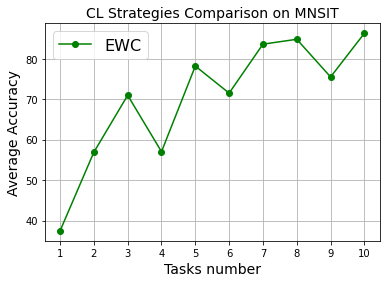

In [28]:
fig, ax = plt.subplots()
plt.plot([1, 2, 3,4,5,6,7,8,9,10], ewc_accs, '-o', label="EWC", color = 'g')
plt.xlabel('Tasks number', fontsize=14)
ax.xaxis.label.set_color('black')
ax.yaxis.label.set_color('black')
plt.ylabel('Average Accuracy', fontsize=14)

ax.grid()
plt.title('CL Strategies Comparison on MNSIT', fontsize=14);
plt.xticks([1, 2, 3,4,5,6,7,8,9,10])
plt.legend(prop={'size': 16})

**As we imporved the EWC model from the starter code, we can see the acc for EWC imporved from the benchmark's 74% to 85.78%.**

##Exploring on the EWC lambda:
Since the $\lambda$ in our EWC loss function decides how important the previous task's parameters when compared to the new task, so we would want to find the best $\lambda$ that fits our model which provides better accurracy:

In this part, we explores different $\lambda$ values and run each of them for three tasks and then plot them together to find the best $\lambda$ value for our model.

From the experiment, we can see the best $\lambda$ value for our MNIST dataset is 0.35, which we used in our PART EWC training above for computing the loss fucntion.

In [25]:
lam_dic = []
for i in range(10,100,5):
    test_lam = round(i*0.01,2)
    lam_dic.append(test_lam)

In [26]:
i = 0
lam_acc =[]

for lambda_i in lam_dic: 
    print("current lambda: ", lambda_i)
    lam_diff_ewc_acc = []
    model = MLP().to(device)
    optimizer = optim.Adadelta(model.parameters())
    for id, task in enumerate(tasks[:3]):
        avg_acc = 0
        print("Training on task: ", id)

        (x_train, t_train), _ = task

        for epoch in range(1, 3):
            train_ewc(model, device, id, x_train, t_train, optimizer, epoch,lambda_i)
            on_task_update(id, x_train, t_train)

        for id_test, task in enumerate(tasks[:3]):
            print("Testing on task: ", id_test)
            _, (x_test, t_test) = task
            acc = test(model, device, x_test, t_test)
            avg_acc = avg_acc + acc

        print("Avg acc: ", avg_acc / 3)
        lam_diff_ewc_acc.append(avg_acc / 3)
    lam_acc.append(lam_diff_ewc_acc)

current lambda:  0.1
Training on task:  0
Train Epoch: 1 	Loss: 0.144918
Train Epoch: 2 	Loss: 0.094884
Testing on task:  0
Test set: Average loss: 0.0001, Accuracy: 9681/10000 (97%)

Testing on task:  1
Test set: Average loss: 0.0045, Accuracy: 1656/10000 (17%)

Testing on task:  2
Test set: Average loss: 0.0032, Accuracy: 2932/10000 (29%)

Avg acc:  47.56333333333333
Training on task:  1
Train Epoch: 1 	Loss: 0.148728
Train Epoch: 2 	Loss: 0.149343
Testing on task:  0
Test set: Average loss: 0.0022, Accuracy: 4354/10000 (44%)

Testing on task:  1
Test set: Average loss: 0.0001, Accuracy: 9541/10000 (95%)

Testing on task:  2
Test set: Average loss: 0.0036, Accuracy: 2209/10000 (22%)

Avg acc:  53.68
Training on task:  2
Train Epoch: 1 	Loss: 0.204933
Train Epoch: 2 	Loss: 0.136081
Testing on task:  0
Test set: Average loss: 0.0027, Accuracy: 3941/10000 (39%)

Testing on task:  1
Test set: Average loss: 0.0012, Accuracy: 6462/10000 (65%)

Testing on task:  2
Test set: Average loss: 0.

###Plotting the lambda result

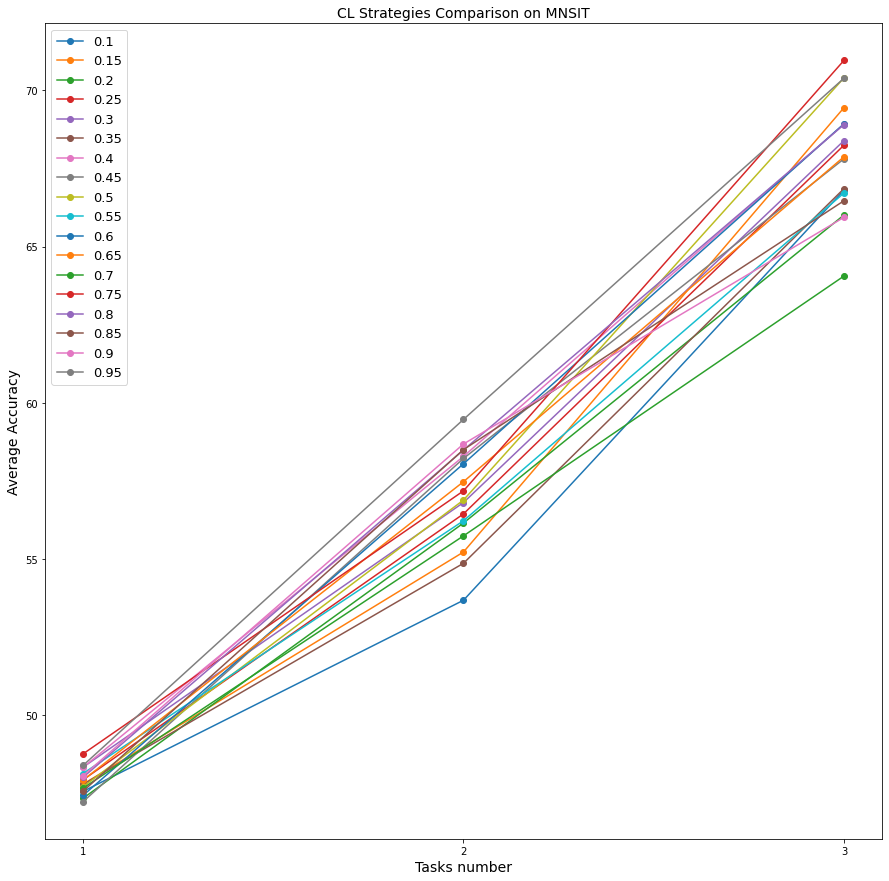

In [27]:
fig, ax = plt.subplots(figsize=(15,15))
ax.xaxis.label.set_color('black')
ax.yaxis.label.set_color('black')

n = 0.1
for i in lam_acc: 
    plt.plot([1, 2, 3],i, '-o', label= n)
    plt.xlabel('Tasks number', fontsize=14)
    plt.ylabel('Average Accuracy', fontsize=14)
    ax.grid()
    plt.title('CL Strategies Comparison on MNSIT', fontsize=14);
    plt.xticks([1, 2, 3])
    plt.legend(prop={'size': 13})
    n += 0.05
    n = round(n,2)

#Conclusion
We formalized the scenario of continual learning. First, we defined training and evaluation protocols
to assess the quality of models in terms of their accuracy, as well as their ability to transfer knowledge
forward and backward between tasks. Second, we introduced EWC, a simple model that leverages by constraining important parameters to stay close to their old values when performing new tasks therby
avoid forgetting and favor positive backward transfer. Our experiments
demonstrate the competitive performance of EWC against the state-of-the-art.

#References Used

https://drive.google.com/file/d/16C9LAshFLqIcj8IQ_ud6WCH9VkrByo_E/view?usp=sharing

http://papers.nips.cc/paper/7225-gradient-episodic-memory-for-continual-learning.pdf

https://github.com/ruinanzhang/Rotated_MNIST_Continual_Learning/blob/master/Rotated_MNIST_EWC.ipynb

https://github.com/kuc2477/pytorch-ewc
